# Buck in pulsed frequency mode

Take a look at the [Buck model](buck.ipynb) first, it will make this model easier to understand.

Assume a buck pulsed frequency mode converter as shown below.

![](../media/l9_sw_arch.svg)

Setup the variables, and the state vectors

In [11]:
import numpy as np
u = 1e-6                        # A micro unit
L = 5 * u                       # 1 uH
Rs = 1                          # Resistance in switches
C = 1 * u                       # 1 uF
R = 1000                        # Load resistor
VDDH = 1.8                      # VDD voltage
VO_initial = 0.99                  # Initial output voltage
VREF = 1.0                      # Wanted output voltage
N = 2**18                       # Number of samples
t_end = 10e-3                    # Time to simulate
t_switch = 0.5e-6               # PMOS switch on time

In [12]:
t = np.linspace(0,t_end,num=N)      # Time vector
vo = np.ones(N)*VO_initial      # Output voltage
ix = np.zeros(N)                # Current in inductor
vx = np.zeros(N)                # Voltage across inductor
v1 = np.zeros(N)                # Voltage at left side of inductor
io = np.zeros(N)                # Current drawn from output
vstate = np.zeros(N)                 # PMOS on
ivdd = np.zeros(N)              # Current drawn from VDD

Assume the following state machine

![](../media/l9_sw_state.svg)

If the output voltage is lower than VREF then turn on the PMOS for t_switch time.

If the current in the inductor is less than 0 (equivalent to zero voltage across NMOS), then turn off the NMOS.

In [13]:

state = 0  #0 = IDLE, 1 = UP, DWN = 2
t_start = 0
for i in range(1,N):
    ts = t[i] 

    # Delta time
    dt = (t[i]-t[i-1])

    #Voltage across the inductor
    if(state == 0): # IDLE
        pmos = 0
        vx[i] = -100*ix[i-1] # Want to model a high impedance. This works, but a bit nasty
        if(vo[i-1] < VREF):
            state = 1
            t_start = ts
    elif(state == 1): # UP (PMOS on)
        vx[i] = VDDH - Rs*ix[i-1] - vo[i-1] 
        pmos = 1
       
        if(ts - t_start > t_switch):
            state = 2
    elif(state == 2): # DOWN (NMOS on)
        pmos = 0
        vx[i] = 0 - Rs*ix[i-1] - vo[i-1] 
        if(ix[i-1] < 0):
            state = 0

    vstate[i] = state
    # Current in inductor, use trapezoidal approximation of area
    ix[i] = ix[i-1] + 1/L * (vx[i] + vx[i-1])/2*dt 

    if(pmos):
        ivdd[i] = ix[i]

    # Output current
    io[i] = 1/R * vo[i]

    # Output voltage
    vo[i] = vo[i-1] + 1/C * ( (ix[i] + ix[i-1])/2 - (io[i] + io[i-1])/2)*dt


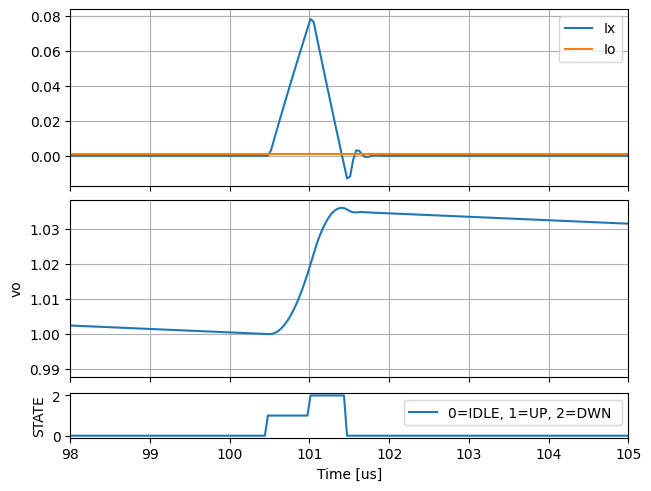

In [16]:
import matplotlib.pyplot as plt
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, constrained_layout=True,sharex=True,gridspec_kw={'height_ratios':[4,4,1]})

ax0.plot(t/u,ix,label="Ix")
ax0.plot(t/u,io,label="Io")
ax0.legend()
ax0.grid('both')
plt.xlabel("Time [us]")
ax1.grid('both')
ax1.plot(t/u,vo)
ax1.set_ylabel("vo")
ax2.plot(t/u,vstate,label="0=IDLE, 1=UP, 2=DWN ")
plt.legend()
plt.ylabel("STATE")


#ax0.set_ylim(-0.06,0.06)
#ax1.set_ylim(0.987,0.990)
plt.xlim(98,105)


plt.xlabel("Time [us]")
plt.savefig("../media/l07_buck_pfm_fig_save.pdf")

In [15]:
vo_avg = np.mean(vo[int(N/2):])
ix_avg = np.mean(ix[int(N/2):])
io_avg = np.mean(io[int(N/2):])
ivdd_avg = np.mean(ivdd[int(N/2):])
pwr_vdd = ivdd_avg*VDDH
pwr_vo = vo_avg*io_avg
efficiency = pwr_vo/pwr_vdd*100
m = 1e-3
print("Output voltage =  %.4g mV" % (vo_avg/m))
print("Inductor current = %.4g mA" % (ix_avg/m))
print("Load current = %.4g mA" % (io_avg/m))
print("VDDH current = %.4g mA" % (ivdd_avg/m))
print("VDDH Power = %.4g mW" % (pwr_vdd/m))
print("VO Power = %.4g mW" % (pwr_vo/m))
print("Efficiency = %.4g pct" % (efficiency))


Output voltage =  1018 mV
Inductor current = 0.9905 mA
Load current = 0.99 mA
VDDH current = 0.6056 mA
VDDH Power = 1.09 mW
VO Power = 1.007 mW
Efficiency = 92.41 pct
